# Build corpus

In this notebook, we identify which papers we want in our corpus, based on their metadata. Since we need astrophysics subcategories for model evaluation, we need each paper in our corpus to contain at least one astrophysics subcategory. We found that all papers within the time range of 2009 - 2019 fit this criteria. We excluded papers from 2020, since the year isn't over yet.

We also identify papers whose fulltexts we successfully extracted and converted.

We re-save metadata.csv with three additional columns: `subcategories`, `in_range`, and `has_fulltext`.

## 1. Setup

Load dependencies and globals.

In [2]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

GLOBALS = pickle.load(open('../data/globals.p', 'rb'))

Load metadata.

In [28]:
metadata = pd.read_csv(GLOBALS['absolute_filepaths']['metadata'],
                       dtype={'filename': str,
                              'filename_parsed': str,
                              'identifier': str,
                              'updated': str,
                              'doi': str}, 
                       parse_dates=['date_retrieved'])

print('Papers we have metadata for: ' + str(len(metadata)))

Papers we have metadata for: 274402


In [30]:
metadata.columns

Index(['identifier', 'filename', 'spec', 'title', 'datestamp', 'created',
       'updated', 'authors', 'categories', 'journal', 'doi', 'abstract',
       'comments', 'date_retrieved', 'filename_parsed'],
      dtype='object')

## 2. Filter papers based on metadata

In [31]:
acceptable_subcats = {'astro-ph.SR': 'Solar and Stellar Astrophysics',
                      'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
                      'astro-ph.GA': 'Astrophysics of Galaxies',
                      'astro-ph.HE': 'High Energy Astrophysical Phenomena',
                      'astro-ph.EP': 'Earth and Planetary Astrophysics',
                      'astro-ph.IM': 'Instrumentation and Methods for Astrophysics'}

Find each paper's astrophysics subcategories.

In [32]:
cats = metadata['categories'].str.split(' ')           # Get all categories for each paper
subcats = []            

for i, _ in enumerate(cats):                           # For each paper,
    temp = []                                          # create a temporary list to hold its subcategories and
    has_subcat = False                                 # set toggle that we have detected no subcategories yet
    for j,_ in enumerate(cats[i]):                     # For each of the paper's categories,
        if cats[i][j] in acceptable_subcats.keys():    # if the category is a subcategory
            temp.append(cats[i][j])                    # add it to the temporary list
            has_subcat = True                          # and toggle that we have detected a subcategory
            
        if j == (len(cats[i]) - 1):                    # When done looking at the last category for that paper,
            if not has_subcat:                         # if that paper had no subcategories,
                subcats.append(None)                   # add none to the master list
            else:                
                subcats.append(temp)                   # otherwise add its subcategories to the master list
                
metadata['subcategories'] = subcats
papers_with_no_subcats = np.where(metadata['subcategories'].isna())[0]
print('Number of papers without subcategory labels: ' + str(len(papers_with_no_subcats)))

Number of papers without subcategory labels: 105282


We will need to exclude at least 105,283 papers when forming our corpus, because they contain no astrophysics subcategories.

Will this change the distribution of years?

In [33]:
years = pd.to_datetime(metadata['created']).apply(lambda x: x.year)
years_filtered = years.drop(papers_with_no_subcats)
years_count = years.value_counts()
years_filtered_count = years_filtered.value_counts()

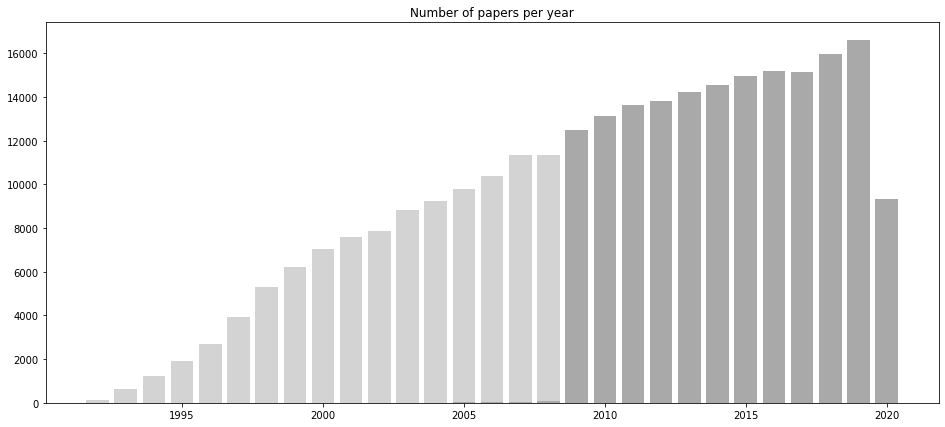

In [34]:
plt.figure(figsize=(16,7))
plt.bar(years_count.keys(), years_count.values, color='lightgray')
plt.bar(years_filtered_count.keys(), years_filtered_count.values, color='darkgray')
plt.title('Number of papers per year')
plt.show()

It definitely changes the distribution of years. It appears that arXiv did not require that astrophysics submissions include a subcategory until 2009, because there are very few papers before 2009 that contain subcategories, whereas it appears that all papers in and after 2009 do.

Confirm this by checking whether there are any papers created in or after 2009 that contain no subcategory.

In [18]:
any(years.take(papers_with_no_subcats).value_counts().keys() >= 2009)

False

We have confirmed that all papers created in or after 2009 contain subcategories, so we will include in our corpus papers from the time range 2009 - 2019, excluding 2020 as it is not yet over. 

Set this time range as global variables in src/set_globals.py, in `corpus_start_year` and `corpus_end_year`, re-make the pickled globals.p file and rerun cell 1 to reload it. 

In [21]:
papers_out_of_range = [i for i, isInRange in enumerate(years.apply(lambda x: x < GLOBALS['start'] or x > GLOBALS['end'])) if isInRange]
print('Number of papers outside 2009-2019: ' + str(len(papers_out_of_range)))
print('Number of papers within 2009-2019: ' + str(len(metadata) - len(papers_out_of_range)))

Number of papers outside 2009-2019: 114777
Number of papers within 2009-2019: 159625


We will build our corpus with the 159,625 papers that have astrophysics subcategories.

Mark these papers as being in range in the metadata.

In [46]:
metadata['in_range'] = years.apply(lambda x: x >= GLOBALS['start'] and x <= GLOBALS['end'])
metadata.to_csv(GLOBALS['absolute_filepaths']['metadata'], index=False)

Notes:
- Although we do not pay attention to this in our selection process/evaluation approach, each paper also has a primary category, and this category may not necessarily be an astrophysics subcategory or even the general astrophysics category. According to according to the (docs)[https://arxiv.org/help/arxiv_identifier_for_services], the secondary categories are in alphabetical order, whereas the primary category is the first category listed. 

## 3. Filter papers based on fulltext conversion results

In [3]:
metadata = pd.read_csv(GLOBALS['absolute_filepaths']['metadata'],
                       dtype={'filename': str,
                              'filename_parsed': str,
                              'identifier': str,
                              'updated': str,
                              'doi': str,
                              'in_range': bool, # FROM THIS NOTEBOOK, PART 2
                              'has_xml': bool}, # FROM EXTRACT_AND_CONVERT_PAPERS.IPYNB 
                       parse_dates=['date_retrieved'])

In [5]:
corpus = metadata[metadata['has_xml'] & metadata['in_range']]

In [1]:
corpus[[0]

NameError: name 'corpus' is not defined

Corpus contains 145,437 papers. 